# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from tqdm import tqdm
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# First Look at Data

### 1- Portfolio

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Looking at the portfolio, I see 10 different types of offer id's. Each offer has a reward value between 0-10 and difficulty between 0-20. 

I see that each offer has a specific channel bundle associated with it. This might be a marketing decision and effectiveness of each channel can be studied seperately. But for this study, I am going to ignore the channels since it is out of scope. 

### 2- Profile

In [4]:
profile.head() 

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


First thing that grabs my attention in profile data is the repeated 118 for age values. Let's dig age information a little deeper.

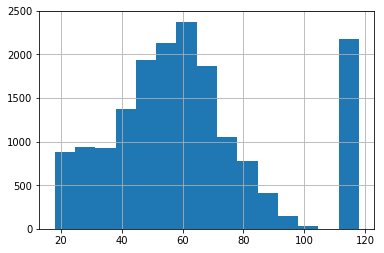

In [5]:
profile['age'].hist(bins=15)

As can be seen from the histogram, there is quite some 118's indeed and it is clearly an outlier just by looking at the histogram(if we ignore the fact that there is only 9 verified people who lived past 117 years. 

This is clearly due signup form forcing users to enter birt date and selection starting from 1900 or system defaulting empty age values to year 1900. No matter what, we should acknowledge that it is not correct and treat it properly.

Rest of the age data has a normal distribution. I see the mean of the distribution to be around 50 years old, which is significantly higher than my expectations. This is probably due the nature of simulation data that I am given. At this point I am going to make conclusions based on this dataset and assume it is a proper representation of customers. There is cutoff at an age of 18 which clearly is another signup limitation.

Let's see if age distribution is similar for all genders:

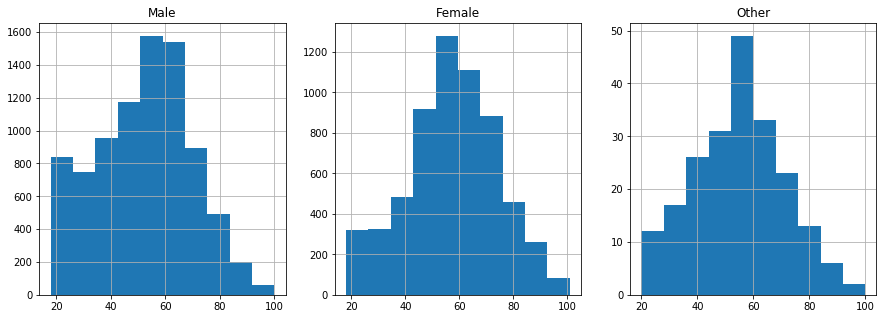

In [6]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax1 = profile[profile['gender']=='M']['age'].hist()
ax2 = fig.add_subplot(132)
ax2= profile[profile['gender']=='F']['age'].hist()
ax3 = fig.add_subplot(133)
ax3= profile[profile['gender']=='O']['age'].hist()
ax1.title.set_text('Male')
ax2.title.set_text('Female')
ax3.title.set_text('Other')

Looks like the distribution average roughly holds for all genders. We can see the total number of male users is higher.

### 3- Transcript

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Transcript is the table where the user behaviour and interactions with offers lie. I need to map each event and offer with their corresponding personal and offer details. In order to do so I need to clean he value column and get rid of extra text. I am curious on variety of event types:

In [8]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

# Data Cleaning

### 1- Portfolio

In [9]:
portfolio_clean = pd.concat((portfolio,pd.get_dummies(portfolio['offer_type'])), axis=1).drop(columns=['offer_type'],axis=0)

In [10]:
portfolio_clean.rename(columns={'channels':'offer_channels',
                                'difficulty':'offer_difficulty',
                               'id':'offer_id',
                               'reward':'offer_reward',
                               'bogo':'offer_type_bogo',
                               'discount':'offer_type_discount',
                               'informational':'offer_type_informational'},inplace=True)

In [11]:
portfolio_clean.head(3)

,offer_channels,offer_difficulty,duration,offer_id,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1


## 2- Profile

Second step is cleaning the outlier ages in profile data.

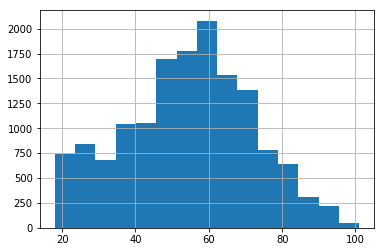

In [12]:
profile_clean = profile.copy()
profile_clean['age'] = profile_clean['age'].apply(lambda x: np.nan if x == 118 else x)
profile_clean['age'].hist(bins=15)

For this project, we are asked to derive conclusions based on the demographics data. Therefore, we don't need to process transactions from user profiles where all three Age, Income, Gender information is not defined. Let's drop those users.

In [13]:
profile_clean = profile_clean[(profile_clean['age'].notnull()) & (profile_clean['gender'].notnull()) & (profile_clean['income'].notnull())]
profile_clean.head(3)

,age,became_member_on,gender,id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0


In [14]:
profile_clean['became_member_on'] = profile_clean['became_member_on'].apply(lambda x: datetime(year=int(str(x)[0:4]), month=int(str(x)[4:6]), day=int(str(x)[6:8])))

In [15]:
profile_clean.rename(columns={'age':'user_age',
                                'difficulty':'offer_difficulty',
                               'gender':'user_gender',
                               'id':'user_id',
                               'income':'user_income'},inplace=True)

In [16]:
profile_clean.head(3)

,user_age,became_member_on,user_gender,user_id,user_income
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0


## Transcript

First, I would like to understand how many different types of transactions are listed.

In [17]:
transaction_types=set()
transcript['value'].apply(lambda x: list(x.keys()))
for i in range(transcript['value'].shape[0]):
    for transaction in list(transcript['value'].iloc[i].keys()):
        transaction_types.add(transaction)
transaction_types

{'amount', 'offer id', 'offer_id', 'reward'}

Clearly the values for "offer_id" and "offer id" should be united. 

In [18]:
values = transcript['value'].apply(pd.Series)

In [19]:
values['offer_id'] = np.logical_or(values['offer id'].fillna(0),values['offer_id'].fillna(0))
values = values.drop(['offer id'],axis=1)

In [20]:
transcript_clean = pd.concat([transcript,values],axis=1,sort=False).drop(['value','reward'],axis=1)

In [21]:
transcript_clean.head(3)

,event,person,time,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5


In [22]:
transcript_clean.rename(columns={'person':'user_id'},inplace=True)

In [23]:
transcript_clean.head(3)

,event,user_id,time,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5


I suspect amount values to be nan for all events but transaction, and transactions not being tracked related to offers. Let's check.

In [24]:
transcript_clean[transcript_clean['amount'].notnull()]['event'].unique()

array(['transaction'], dtype=object)

In [25]:
transcript_clean[transcript_clean['event']=='transaction'].head(3)

,event,user_id,time,amount,offer_id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,0
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,0


As I suspected, it is the case. This information may help me in the future.

## Data Transformation

It is time to combine the dataframes into a single dataframe to before starting analysis. I know that profile and transcript dataframes share user id's in common and transcript and portfolio has offer_id's in common.

In [26]:
transcript_df = transcript_clean.merge(profile_clean,how='inner',on=['user_id']).merge(
    portfolio_clean,how='outer',on=['offer_id'])
transcript_df.head(3)

,event,user_id,time,amount,offer_id,user_age,became_member_on,user_gender,user_income,offer_channels,offer_difficulty,duration,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,5.0,1.0,0.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,5.0,1.0,0.0,0.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,5.0,1.0,0.0,0.0


# CRISP-DM

It is time to process our dataframe to extract useful statistics that can impact our business decisions.

We would like to propose our customers the best possible offer so that they will be pleased to use it. Otherwise, repeated offers can create a negative impression. So, if we can understand the customer behaviour not only we improve our sales but also improve the customer satisfaction. This will also improve the use of our app, webpage and create brand loyalty.

Before going deeper into demographics, we can look into overall performance of our offers. One would expect lowering the difficulty or increasing the reward will end up with higher offer completion. Otherwise, company may need to redesign the offers or demographics for that offer. In order to check for the validity of this idea I am going to count the number of times each offer was sent out and ended up being completed.

For this study, I am going to count an offer as intentionally completed, only if it is viewed and completed. 

In [27]:
transcript_received = transcript_clean[transcript_clean['event']=='offer received'].drop(columns=['amount','event'])
transcript_viewed = transcript_clean[transcript_clean['event']=='offer viewed'].drop(columns=['amount','event'])
transcript_completed = transcript_clean[transcript_clean['event']=='offer completed'].drop(columns=['amount','event'])
transcript_transaction = transcript_clean[transcript_clean['event']=='transaction']

We would like to calculate the beginning and end of each offer. In order to do so, we need to get the duration information from the portfolio dataframe. Let's merge them.

In [28]:
duration_dictionary = dict()
for offer in list(portfolio_clean['offer_id']):
    duration_dictionary[offer]= portfolio_clean[portfolio_clean['offer_id']==offer]['duration'].values[0]

In [29]:
transcript_received['end']=0
transcript_received.head()

,user_id,time,offer_id,end
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [30]:
transcript_received['end']=transcript_received.apply(
    lambda x: duration_dictionary[x['offer_id']]*24 + x['time'],axis=1)

In [31]:
transcript_received = transcript_received.merge(portfolio_clean,on=['offer_id'],how='outer')

Now, we now when each order is received and how long it will be valid for. Let's calculate an 'end' time for each offer based on it's transcript date and create a column for that and remove 

In [32]:
df_transcript = transcript_received.merge(
    transcript_viewed,how='outer',on=['user_id','offer_id'],suffixes=('','_viewed')).merge(
    transcript_completed,how='outer',on=['user_id','offer_id'],suffixes=('','_completed'))

In [33]:
def transactions_intentional_complete(df,profile):
    output_df=pd.DataFrame()
    user_list = profile['user_id'].unique()
    for user in tqdm(user_list):
        temp_df = df[df['user_id']==user]
        temp_df=temp_df[(temp_df['time_completed']>=temp_df['time']) & 
                        (temp_df['time_completed']>=temp_df['time_viewed']) & 
                        (temp_df['time_completed']<=temp_df['end']) & 
                        (temp_df['time_viewed']<=temp_df['end']) & 
                        (temp_df['time_viewed']>= temp_df['time'])].sort_values(by=['time','time_viewed','time_completed'])
        temp_df.drop_duplicates(subset=['time'], inplace=True)
        output_df=output_df.append(temp_df)
    return output_df

In [70]:
def transactions_nonintentional_complete(df,profile):
    output_df=pd.DataFrame()
    user_list = profile['user_id'].unique()
    for user in tqdm(user_list):
        temp_df = df[df['user_id']==user]
        temp_df=temp_df[
            (temp_df['time_completed']>=temp_df['time']) & 
            (temp_df['time_completed']<=temp_df['end'])  &
            ( (temp_df['time_viewed']>temp_df['time_completed']) | (temp_df['time_viewed'].isnull()) )
        ].sort_values(by=['time','time_completed'])
        temp_df.drop_duplicates(subset=['time'], inplace=True)
        output_df=output_df.append(temp_df)
    return output_df

In [34]:
transcript_intentional_completes = transactions_intentional_complete(df_transcript,profile_clean)
transcript_intentional_completes.to_pickle("./intentional_completes.pkl")

100%|██████████| 14825/14825 [08:44<00:00, 28.25it/s]


In [71]:
transactions_nonintentional_completes=transactions_nonintentional_complete(df_transcript,profile_clean)
transactions_nonintentional_completes.to_pickle("./nonintentional_completes.pkl")



  0%|          | 0/14825 [00:00<?, ?it/s]

  0%|          | 4/14825 [00:00<06:14, 39.60it/s]

  0%|          | 8/14825 [00:00<06:27, 38.24it/s]

  0%|          | 12/14825 [00:00<06:46, 36.42it/s]

  0%|          | 17/14825 [00:00<06:28, 38.11it/s]

  0%|          | 21/14825 [00:00<06:40, 36.94it/s]

  0%|          | 25/14825 [00:00<06:46, 36.37it/s]

  0%|          | 30/14825 [00:00<06:28, 38.07it/s]

  0%|          | 34/14825 [00:00<06:49, 36.12it/s]

  0%|          | 38/14825 [00:01<06:46, 36.39it/s]

  0%|          | 43/14825 [00:01<06:50, 36.03it/s]

  0%|          | 47/14825 [00:01<07:05, 34.71it/s]

  0%|          | 51/14825 [00:01<06:50, 35.95it/s]

  0%|          | 55/14825 [00:01<06:47, 36.27it/s]

  0%|          | 59/14825 [00:01<06:53, 35.71it/s]

  0%|          | 63/14825 [00:01<07:04, 34.78it/s]

  0%|          | 67/14825 [00:01<06:53, 35.71it/s]

  0%|          | 71/14825 [00:01<06:46, 36.30it/s]

  1%|          | 75/14825 [00:02<06:41, 36.72it/s]

  1%|          | 79/1

  4%|▍         | 636/14825 [00:18<06:48, 34.75it/s]

  4%|▍         | 640/14825 [00:18<06:37, 35.69it/s]

  4%|▍         | 644/14825 [00:18<06:30, 36.28it/s]

  4%|▍         | 648/14825 [00:18<06:33, 36.01it/s]

  4%|▍         | 652/14825 [00:18<06:35, 35.82it/s]

  4%|▍         | 656/14825 [00:18<06:51, 34.40it/s]

  4%|▍         | 660/14825 [00:18<06:58, 33.82it/s]

  4%|▍         | 664/14825 [00:18<06:44, 34.99it/s]

  5%|▍         | 668/14825 [00:18<06:41, 35.30it/s]

  5%|▍         | 672/14825 [00:19<07:01, 33.55it/s]

  5%|▍         | 676/14825 [00:19<07:13, 32.66it/s]

  5%|▍         | 680/14825 [00:19<07:28, 31.54it/s]

  5%|▍         | 684/14825 [00:19<07:49, 30.10it/s]

  5%|▍         | 688/14825 [00:19<07:42, 30.58it/s]

  5%|▍         | 692/14825 [00:19<07:59, 29.48it/s]

  5%|▍         | 695/14825 [00:19<08:10, 28.78it/s]

  5%|▍         | 699/14825 [00:20<07:54, 29.74it/s]

  5%|▍         | 704/14825 [00:20<07:13, 32.60it/s]

  5%|▍         | 708/14825 [00:20<07:17, 32.26

  9%|▊         | 1261/14825 [00:36<06:07, 36.89it/s]

  9%|▊         | 1265/14825 [00:37<06:21, 35.56it/s]

  9%|▊         | 1269/14825 [00:37<06:28, 34.86it/s]

  9%|▊         | 1273/14825 [00:37<06:32, 34.56it/s]

  9%|▊         | 1277/14825 [00:37<06:47, 33.25it/s]

  9%|▊         | 1281/14825 [00:37<06:46, 33.36it/s]

  9%|▊         | 1285/14825 [00:37<06:50, 33.02it/s]

  9%|▊         | 1289/14825 [00:37<07:23, 30.53it/s]

  9%|▊         | 1293/14825 [00:37<07:23, 30.53it/s]

  9%|▊         | 1297/14825 [00:38<07:34, 29.78it/s]

  9%|▉         | 1301/14825 [00:38<07:10, 31.42it/s]

  9%|▉         | 1305/14825 [00:38<07:23, 30.51it/s]

  9%|▉         | 1309/14825 [00:38<07:25, 30.31it/s]

  9%|▉         | 1313/14825 [00:38<07:18, 30.79it/s]

  9%|▉         | 1317/14825 [00:38<07:08, 31.51it/s]

  9%|▉         | 1322/14825 [00:38<06:37, 34.00it/s]

  9%|▉         | 1326/14825 [00:38<07:12, 31.19it/s]

  9%|▉         | 1330/14825 [00:39<06:54, 32.58it/s]

  9%|▉         | 1334/14825 

 13%|█▎        | 1873/14825 [00:55<06:08, 35.19it/s]

 13%|█▎        | 1878/14825 [00:55<05:49, 37.00it/s]

 13%|█▎        | 1882/14825 [00:55<06:17, 34.25it/s]

 13%|█▎        | 1886/14825 [00:55<06:23, 33.71it/s]

 13%|█▎        | 1890/14825 [00:55<06:23, 33.77it/s]

 13%|█▎        | 1894/14825 [00:55<06:27, 33.38it/s]

 13%|█▎        | 1898/14825 [00:56<06:35, 32.71it/s]

 13%|█▎        | 1902/14825 [00:56<06:38, 32.42it/s]

 13%|█▎        | 1906/14825 [00:56<06:56, 31.01it/s]

 13%|█▎        | 1910/14825 [00:56<06:40, 32.29it/s]

 13%|█▎        | 1914/14825 [00:56<06:45, 31.82it/s]

 13%|█▎        | 1918/14825 [00:56<06:35, 32.65it/s]

 13%|█▎        | 1922/14825 [00:56<06:25, 33.51it/s]

 13%|█▎        | 1926/14825 [00:56<06:22, 33.71it/s]

 13%|█▎        | 1930/14825 [00:57<06:43, 31.98it/s]

 13%|█▎        | 1934/14825 [00:57<06:44, 31.84it/s]

 13%|█▎        | 1938/14825 [00:57<06:42, 32.04it/s]

 13%|█▎        | 1942/14825 [00:57<06:36, 32.49it/s]

 13%|█▎        | 1946/14825 

 17%|█▋        | 2488/14825 [01:13<06:04, 33.85it/s]

 17%|█▋        | 2492/14825 [01:13<05:55, 34.65it/s]

 17%|█▋        | 2496/14825 [01:13<05:54, 34.78it/s]

 17%|█▋        | 2500/14825 [01:13<06:01, 34.07it/s]

 17%|█▋        | 2504/14825 [01:14<06:04, 33.85it/s]

 17%|█▋        | 2508/14825 [01:14<06:11, 33.19it/s]

 17%|█▋        | 2512/14825 [01:14<06:22, 32.19it/s]

 17%|█▋        | 2516/14825 [01:14<06:10, 33.25it/s]

 17%|█▋        | 2521/14825 [01:14<05:49, 35.25it/s]

 17%|█▋        | 2525/14825 [01:14<05:40, 36.15it/s]

 17%|█▋        | 2529/14825 [01:14<06:19, 32.43it/s]

 17%|█▋        | 2533/14825 [01:14<06:16, 32.61it/s]

 17%|█▋        | 2537/14825 [01:15<06:30, 31.43it/s]

 17%|█▋        | 2541/14825 [01:15<06:45, 30.31it/s]

 17%|█▋        | 2545/14825 [01:15<06:41, 30.58it/s]

 17%|█▋        | 2549/14825 [01:15<06:44, 30.36it/s]

 17%|█▋        | 2553/14825 [01:15<06:49, 30.00it/s]

 17%|█▋        | 2557/14825 [01:15<07:01, 29.10it/s]

 17%|█▋        | 2561/14825 

 21%|██        | 3098/14825 [01:32<06:08, 31.81it/s]

 21%|██        | 3102/14825 [01:32<06:21, 30.69it/s]

 21%|██        | 3106/14825 [01:32<06:17, 31.07it/s]

 21%|██        | 3110/14825 [01:32<06:18, 30.98it/s]

 21%|██        | 3114/14825 [01:32<06:37, 29.48it/s]

 21%|██        | 3118/14825 [01:32<06:09, 31.70it/s]

 21%|██        | 3122/14825 [01:32<05:52, 33.22it/s]

 21%|██        | 3127/14825 [01:33<05:27, 35.75it/s]

 21%|██        | 3131/14825 [01:33<05:37, 34.62it/s]

 21%|██        | 3135/14825 [01:33<05:36, 34.76it/s]

 21%|██        | 3139/14825 [01:33<05:54, 32.96it/s]

 21%|██        | 3143/14825 [01:33<05:47, 33.57it/s]

 21%|██        | 3147/14825 [01:33<06:03, 32.13it/s]

 21%|██▏       | 3151/14825 [01:33<06:04, 32.01it/s]

 21%|██▏       | 3155/14825 [01:33<06:00, 32.40it/s]

 21%|██▏       | 3159/14825 [01:34<06:23, 30.43it/s]

 21%|██▏       | 3163/14825 [01:34<06:20, 30.67it/s]

 21%|██▏       | 3167/14825 [01:34<06:10, 31.50it/s]

 21%|██▏       | 3171/14825 

 25%|██▌       | 3710/14825 [01:50<05:56, 31.21it/s]

 25%|██▌       | 3714/14825 [01:50<06:11, 29.89it/s]

 25%|██▌       | 3718/14825 [01:50<06:10, 30.01it/s]

 25%|██▌       | 3722/14825 [01:50<06:09, 30.03it/s]

 25%|██▌       | 3726/14825 [01:51<06:07, 30.18it/s]

 25%|██▌       | 3730/14825 [01:51<06:38, 27.82it/s]

 25%|██▌       | 3734/14825 [01:51<06:18, 29.27it/s]

 25%|██▌       | 3738/14825 [01:51<05:57, 31.02it/s]

 25%|██▌       | 3743/14825 [01:51<05:28, 33.73it/s]

 25%|██▌       | 3748/14825 [01:51<05:10, 35.62it/s]

 25%|██▌       | 3752/14825 [01:51<05:08, 35.84it/s]

 25%|██▌       | 3757/14825 [01:51<04:55, 37.41it/s]

 25%|██▌       | 3761/14825 [01:52<05:09, 35.70it/s]

 25%|██▌       | 3765/14825 [01:52<05:18, 34.68it/s]

 25%|██▌       | 3769/14825 [01:52<05:27, 33.74it/s]

 25%|██▌       | 3773/14825 [01:52<05:50, 31.55it/s]

 25%|██▌       | 3777/14825 [01:52<05:56, 31.02it/s]

 26%|██▌       | 3781/14825 [01:52<05:44, 32.06it/s]

 26%|██▌       | 3785/14825 

 29%|██▉       | 4322/14825 [02:09<05:32, 31.62it/s]

 29%|██▉       | 4326/14825 [02:09<05:49, 30.02it/s]

 29%|██▉       | 4330/14825 [02:09<05:45, 30.38it/s]

 29%|██▉       | 4334/14825 [02:09<05:21, 32.58it/s]

 29%|██▉       | 4338/14825 [02:09<05:20, 32.72it/s]

 29%|██▉       | 4342/14825 [02:09<05:19, 32.82it/s]

 29%|██▉       | 4346/14825 [02:09<05:34, 31.34it/s]

 29%|██▉       | 4350/14825 [02:10<05:13, 33.44it/s]

 29%|██▉       | 4354/14825 [02:10<05:22, 32.43it/s]

 29%|██▉       | 4358/14825 [02:10<05:20, 32.62it/s]

 29%|██▉       | 4362/14825 [02:10<05:20, 32.67it/s]

 29%|██▉       | 4366/14825 [02:10<05:18, 32.86it/s]

 29%|██▉       | 4370/14825 [02:10<05:39, 30.79it/s]

 30%|██▉       | 4374/14825 [02:10<05:19, 32.67it/s]

 30%|██▉       | 4378/14825 [02:10<05:13, 33.36it/s]

 30%|██▉       | 4382/14825 [02:11<05:08, 33.86it/s]

 30%|██▉       | 4386/14825 [02:11<05:16, 33.03it/s]

 30%|██▉       | 4390/14825 [02:11<05:30, 31.55it/s]

 30%|██▉       | 4394/14825 

 33%|███▎      | 4930/14825 [02:27<05:13, 31.57it/s]

 33%|███▎      | 4934/14825 [02:28<05:03, 32.63it/s]

 33%|███▎      | 4938/14825 [02:28<05:01, 32.84it/s]

 33%|███▎      | 4942/14825 [02:28<05:14, 31.43it/s]

 33%|███▎      | 4946/14825 [02:28<05:28, 30.03it/s]

 33%|███▎      | 4950/14825 [02:28<05:33, 29.64it/s]

 33%|███▎      | 4953/14825 [02:28<05:37, 29.23it/s]

 33%|███▎      | 4956/14825 [02:28<05:47, 28.37it/s]

 33%|███▎      | 4960/14825 [02:28<05:21, 30.72it/s]

 33%|███▎      | 4964/14825 [02:29<05:09, 31.84it/s]

 34%|███▎      | 4968/14825 [02:29<05:22, 30.57it/s]

 34%|███▎      | 4972/14825 [02:29<05:41, 28.84it/s]

 34%|███▎      | 4976/14825 [02:29<05:13, 31.40it/s]

 34%|███▎      | 4980/14825 [02:29<05:01, 32.66it/s]

 34%|███▎      | 4984/14825 [02:29<05:15, 31.17it/s]

 34%|███▎      | 4988/14825 [02:29<05:08, 31.86it/s]

 34%|███▎      | 4992/14825 [02:29<05:06, 32.06it/s]

 34%|███▎      | 4996/14825 [02:30<05:06, 32.12it/s]

 34%|███▎      | 5000/14825 

 37%|███▋      | 5529/14825 [02:46<04:50, 31.95it/s]

 37%|███▋      | 5533/14825 [02:46<04:38, 33.32it/s]

 37%|███▋      | 5537/14825 [02:46<04:40, 33.16it/s]

 37%|███▋      | 5542/14825 [02:46<04:23, 35.17it/s]

 37%|███▋      | 5546/14825 [02:47<04:58, 31.13it/s]

 37%|███▋      | 5550/14825 [02:47<05:03, 30.59it/s]

 37%|███▋      | 5554/14825 [02:47<05:03, 30.50it/s]

 37%|███▋      | 5558/14825 [02:47<05:09, 29.90it/s]

 38%|███▊      | 5562/14825 [02:47<05:09, 29.95it/s]

 38%|███▊      | 5566/14825 [02:47<05:16, 29.26it/s]

 38%|███▊      | 5570/14825 [02:47<04:59, 30.94it/s]

 38%|███▊      | 5574/14825 [02:48<05:02, 30.53it/s]

 38%|███▊      | 5578/14825 [02:48<05:11, 29.72it/s]

 38%|███▊      | 5582/14825 [02:48<04:58, 30.93it/s]

 38%|███▊      | 5586/14825 [02:48<04:41, 32.78it/s]

 38%|███▊      | 5590/14825 [02:48<04:53, 31.47it/s]

 38%|███▊      | 5594/14825 [02:48<04:51, 31.70it/s]

 38%|███▊      | 5598/14825 [02:48<04:35, 33.46it/s]

 38%|███▊      | 5602/14825 

 41%|████▏     | 6134/14825 [03:05<04:31, 32.01it/s]

 41%|████▏     | 6138/14825 [03:05<04:25, 32.71it/s]

 41%|████▏     | 6142/14825 [03:05<04:23, 32.98it/s]

 41%|████▏     | 6146/14825 [03:05<04:37, 31.30it/s]

 41%|████▏     | 6150/14825 [03:05<04:45, 30.43it/s]

 42%|████▏     | 6154/14825 [03:05<04:45, 30.32it/s]

 42%|████▏     | 6158/14825 [03:06<04:49, 29.97it/s]

 42%|████▏     | 6162/14825 [03:06<05:00, 28.83it/s]

 42%|████▏     | 6166/14825 [03:06<04:37, 31.18it/s]

 42%|████▏     | 6170/14825 [03:06<04:19, 33.38it/s]

 42%|████▏     | 6174/14825 [03:06<04:08, 34.85it/s]

 42%|████▏     | 6178/14825 [03:06<04:11, 34.38it/s]

 42%|████▏     | 6182/14825 [03:06<04:34, 31.49it/s]

 42%|████▏     | 6186/14825 [03:06<04:27, 32.33it/s]

 42%|████▏     | 6190/14825 [03:06<04:32, 31.69it/s]

 42%|████▏     | 6194/14825 [03:07<04:28, 32.17it/s]

 42%|████▏     | 6198/14825 [03:07<04:42, 30.57it/s]

 42%|████▏     | 6202/14825 [03:07<04:35, 31.35it/s]

 42%|████▏     | 6206/14825 

 45%|████▌     | 6738/14825 [03:23<04:00, 33.59it/s]

 45%|████▌     | 6742/14825 [03:23<03:51, 34.92it/s]

 46%|████▌     | 6746/14825 [03:24<03:58, 33.90it/s]

 46%|████▌     | 6750/14825 [03:24<03:55, 34.25it/s]

 46%|████▌     | 6754/14825 [03:24<04:04, 32.96it/s]

 46%|████▌     | 6758/14825 [03:24<04:06, 32.67it/s]

 46%|████▌     | 6762/14825 [03:24<04:12, 32.00it/s]

 46%|████▌     | 6766/14825 [03:24<04:04, 33.03it/s]

 46%|████▌     | 6770/14825 [03:24<04:16, 31.40it/s]

 46%|████▌     | 6774/14825 [03:24<04:09, 32.27it/s]

 46%|████▌     | 6778/14825 [03:25<04:02, 33.15it/s]

 46%|████▌     | 6782/14825 [03:25<04:05, 32.71it/s]

 46%|████▌     | 6786/14825 [03:25<04:18, 31.06it/s]

 46%|████▌     | 6790/14825 [03:25<04:17, 31.26it/s]

 46%|████▌     | 6794/14825 [03:25<04:26, 30.13it/s]

 46%|████▌     | 6798/14825 [03:25<04:10, 31.99it/s]

 46%|████▌     | 6802/14825 [03:25<04:18, 31.02it/s]

 46%|████▌     | 6806/14825 [03:25<04:24, 30.31it/s]

 46%|████▌     | 6810/14825 

 50%|████▉     | 7346/14825 [03:42<03:27, 36.10it/s]

 50%|████▉     | 7350/14825 [03:42<03:23, 36.78it/s]

 50%|████▉     | 7354/14825 [03:42<03:21, 37.16it/s]

 50%|████▉     | 7358/14825 [03:42<03:19, 37.44it/s]

 50%|████▉     | 7362/14825 [03:42<03:19, 37.32it/s]

 50%|████▉     | 7366/14825 [03:42<03:20, 37.13it/s]

 50%|████▉     | 7370/14825 [03:42<03:22, 36.89it/s]

 50%|████▉     | 7374/14825 [03:42<03:18, 37.56it/s]

 50%|████▉     | 7378/14825 [03:43<03:17, 37.72it/s]

 50%|████▉     | 7382/14825 [03:43<03:15, 38.05it/s]

 50%|████▉     | 7386/14825 [03:43<03:15, 38.06it/s]

 50%|████▉     | 7390/14825 [03:43<03:16, 37.85it/s]

 50%|████▉     | 7394/14825 [03:43<03:15, 38.03it/s]

 50%|████▉     | 7398/14825 [03:43<03:19, 37.31it/s]

 50%|████▉     | 7402/14825 [03:43<03:21, 36.92it/s]

 50%|████▉     | 7406/14825 [03:43<03:23, 36.45it/s]

 50%|████▉     | 7410/14825 [03:43<03:23, 36.52it/s]

 50%|█████     | 7414/14825 [03:43<03:19, 37.08it/s]

 50%|█████     | 7418/14825 

 54%|█████▎    | 7951/14825 [03:59<03:13, 35.61it/s]

 54%|█████▎    | 7955/14825 [03:59<03:15, 35.08it/s]

 54%|█████▎    | 7959/14825 [03:59<03:13, 35.55it/s]

 54%|█████▎    | 7964/14825 [03:59<03:06, 36.86it/s]

 54%|█████▎    | 7968/14825 [03:59<03:02, 37.53it/s]

 54%|█████▍    | 7972/14825 [03:59<03:01, 37.81it/s]

 54%|█████▍    | 7976/14825 [04:00<03:02, 37.57it/s]

 54%|█████▍    | 7980/14825 [04:00<02:58, 38.27it/s]

 54%|█████▍    | 7984/14825 [04:00<03:03, 37.25it/s]

 54%|█████▍    | 7988/14825 [04:00<03:01, 37.71it/s]

 54%|█████▍    | 7992/14825 [04:00<02:59, 38.15it/s]

 54%|█████▍    | 7996/14825 [04:00<02:58, 38.35it/s]

 54%|█████▍    | 8000/14825 [04:00<02:58, 38.28it/s]

 54%|█████▍    | 8004/14825 [04:00<02:56, 38.66it/s]

 54%|█████▍    | 8008/14825 [04:00<02:55, 38.94it/s]

 54%|█████▍    | 8012/14825 [04:00<02:55, 38.79it/s]

 54%|█████▍    | 8016/14825 [04:01<02:56, 38.47it/s]

 54%|█████▍    | 8020/14825 [04:01<02:55, 38.80it/s]

 54%|█████▍    | 8024/14825 

 58%|█████▊    | 8559/14825 [04:16<02:48, 37.13it/s]

 58%|█████▊    | 8563/14825 [04:16<02:46, 37.52it/s]

 58%|█████▊    | 8567/14825 [04:16<02:49, 36.86it/s]

 58%|█████▊    | 8571/14825 [04:16<02:56, 35.44it/s]

 58%|█████▊    | 8575/14825 [04:16<03:11, 32.57it/s]

 58%|█████▊    | 8579/14825 [04:16<03:14, 32.16it/s]

 58%|█████▊    | 8583/14825 [04:16<03:29, 29.81it/s]

 58%|█████▊    | 8587/14825 [04:17<03:25, 30.37it/s]

 58%|█████▊    | 8591/14825 [04:17<03:13, 32.18it/s]

 58%|█████▊    | 8595/14825 [04:17<03:04, 33.84it/s]

 58%|█████▊    | 8599/14825 [04:17<03:00, 34.47it/s]

 58%|█████▊    | 8603/14825 [04:17<03:01, 34.21it/s]

 58%|█████▊    | 8607/14825 [04:17<03:01, 34.29it/s]

 58%|█████▊    | 8611/14825 [04:17<03:11, 32.42it/s]

 58%|█████▊    | 8615/14825 [04:17<03:11, 32.37it/s]

 58%|█████▊    | 8619/14825 [04:18<03:10, 32.58it/s]

 58%|█████▊    | 8623/14825 [04:18<03:06, 33.29it/s]

 58%|█████▊    | 8627/14825 [04:18<03:05, 33.47it/s]

 58%|█████▊    | 8631/14825 

 62%|██████▏   | 9167/14825 [04:33<02:38, 35.72it/s]

 62%|██████▏   | 9171/14825 [04:33<02:48, 33.56it/s]

 62%|██████▏   | 9175/14825 [04:33<02:54, 32.36it/s]

 62%|██████▏   | 9179/14825 [04:34<02:51, 32.96it/s]

 62%|██████▏   | 9183/14825 [04:34<02:44, 34.35it/s]

 62%|██████▏   | 9187/14825 [04:34<02:40, 35.02it/s]

 62%|██████▏   | 9191/14825 [04:34<02:35, 36.18it/s]

 62%|██████▏   | 9195/14825 [04:34<02:37, 35.65it/s]

 62%|██████▏   | 9199/14825 [04:34<02:49, 33.10it/s]

 62%|██████▏   | 9203/14825 [04:34<02:46, 33.85it/s]

 62%|██████▏   | 9207/14825 [04:34<02:55, 31.99it/s]

 62%|██████▏   | 9211/14825 [04:34<02:48, 33.27it/s]

 62%|██████▏   | 9215/14825 [04:35<02:44, 34.14it/s]

 62%|██████▏   | 9219/14825 [04:35<02:44, 33.98it/s]

 62%|██████▏   | 9223/14825 [04:35<02:39, 35.12it/s]

 62%|██████▏   | 9227/14825 [04:35<02:33, 36.35it/s]

 62%|██████▏   | 9231/14825 [04:35<02:32, 36.66it/s]

 62%|██████▏   | 9235/14825 [04:35<02:29, 37.49it/s]

 62%|██████▏   | 9239/14825 

 66%|██████▌   | 9772/14825 [04:51<02:30, 33.50it/s]

 66%|██████▌   | 9776/14825 [04:51<02:40, 31.48it/s]

 66%|██████▌   | 9780/14825 [04:51<02:40, 31.41it/s]

 66%|██████▌   | 9784/14825 [04:51<02:38, 31.88it/s]

 66%|██████▌   | 9788/14825 [04:51<02:39, 31.54it/s]

 66%|██████▌   | 9792/14825 [04:52<02:32, 33.09it/s]

 66%|██████▌   | 9796/14825 [04:52<02:26, 34.36it/s]

 66%|██████▌   | 9800/14825 [04:52<02:27, 34.13it/s]

 66%|██████▌   | 9804/14825 [04:52<02:29, 33.63it/s]

 66%|██████▌   | 9808/14825 [04:52<02:24, 34.77it/s]

 66%|██████▌   | 9812/14825 [04:52<02:22, 35.23it/s]

 66%|██████▌   | 9816/14825 [04:52<02:23, 35.00it/s]

 66%|██████▌   | 9820/14825 [04:52<02:30, 33.36it/s]

 66%|██████▋   | 9824/14825 [04:52<02:31, 32.94it/s]

 66%|██████▋   | 9828/14825 [04:53<02:30, 33.22it/s]

 66%|██████▋   | 9832/14825 [04:53<02:24, 34.46it/s]

 66%|██████▋   | 9836/14825 [04:53<02:33, 32.45it/s]

 66%|██████▋   | 9840/14825 [04:53<02:29, 33.37it/s]

 66%|██████▋   | 9844/14825 

 70%|██████▉   | 10372/14825 [05:09<02:17, 32.38it/s]

 70%|██████▉   | 10376/14825 [05:09<02:13, 33.31it/s]

 70%|███████   | 10380/14825 [05:09<02:17, 32.35it/s]

 70%|███████   | 10384/14825 [05:09<02:12, 33.63it/s]

 70%|███████   | 10388/14825 [05:09<02:07, 34.67it/s]

 70%|███████   | 10392/14825 [05:09<02:05, 35.35it/s]

 70%|███████   | 10396/14825 [05:09<02:12, 33.33it/s]

 70%|███████   | 10400/14825 [05:09<02:17, 32.20it/s]

 70%|███████   | 10404/14825 [05:10<02:13, 33.18it/s]

 70%|███████   | 10408/14825 [05:10<02:18, 31.88it/s]

 70%|███████   | 10412/14825 [05:10<02:14, 32.86it/s]

 70%|███████   | 10416/14825 [05:10<02:19, 31.66it/s]

 70%|███████   | 10420/14825 [05:10<02:24, 30.53it/s]

 70%|███████   | 10424/14825 [05:10<02:20, 31.24it/s]

 70%|███████   | 10428/14825 [05:10<02:14, 32.78it/s]

 70%|███████   | 10432/14825 [05:10<02:08, 34.13it/s]

 70%|███████   | 10436/14825 [05:10<02:06, 34.59it/s]

 70%|███████   | 10440/14825 [05:11<02:17, 31.98it/s]

 70%|█████

 74%|███████▍  | 10964/14825 [05:26<01:59, 32.39it/s]

 74%|███████▍  | 10968/14825 [05:26<02:00, 32.04it/s]

 74%|███████▍  | 10972/14825 [05:27<01:56, 33.14it/s]

 74%|███████▍  | 10976/14825 [05:27<01:55, 33.20it/s]

 74%|███████▍  | 10980/14825 [05:27<01:51, 34.62it/s]

 74%|███████▍  | 10984/14825 [05:27<01:48, 35.40it/s]

 74%|███████▍  | 10988/14825 [05:27<01:46, 35.97it/s]

 74%|███████▍  | 10992/14825 [05:27<01:50, 34.68it/s]

 74%|███████▍  | 10996/14825 [05:27<01:58, 32.43it/s]

 74%|███████▍  | 11000/14825 [05:27<02:00, 31.84it/s]

 74%|███████▍  | 11004/14825 [05:28<01:58, 32.19it/s]

 74%|███████▍  | 11008/14825 [05:28<01:58, 32.29it/s]

 74%|███████▍  | 11012/14825 [05:28<01:52, 33.75it/s]

 74%|███████▍  | 11016/14825 [05:28<01:52, 33.79it/s]

 74%|███████▍  | 11020/14825 [05:28<01:49, 34.89it/s]

 74%|███████▍  | 11024/14825 [05:28<01:46, 35.60it/s]

 74%|███████▍  | 11028/14825 [05:28<01:48, 35.07it/s]

 74%|███████▍  | 11032/14825 [05:28<01:47, 35.45it/s]

 74%|█████

 78%|███████▊  | 11556/14825 [05:44<01:41, 32.07it/s]

 78%|███████▊  | 11560/14825 [05:44<01:37, 33.42it/s]

 78%|███████▊  | 11564/14825 [05:44<01:37, 33.31it/s]

 78%|███████▊  | 11568/14825 [05:44<01:40, 32.42it/s]

 78%|███████▊  | 11572/14825 [05:44<01:36, 33.68it/s]

 78%|███████▊  | 11576/14825 [05:45<01:39, 32.51it/s]

 78%|███████▊  | 11580/14825 [05:45<01:35, 34.09it/s]

 78%|███████▊  | 11584/14825 [05:45<01:31, 35.39it/s]

 78%|███████▊  | 11588/14825 [05:45<01:32, 34.84it/s]

 78%|███████▊  | 11592/14825 [05:45<01:31, 35.28it/s]

 78%|███████▊  | 11596/14825 [05:45<01:36, 33.62it/s]

 78%|███████▊  | 11600/14825 [05:45<01:38, 32.71it/s]

 78%|███████▊  | 11604/14825 [05:45<01:36, 33.31it/s]

 78%|███████▊  | 11608/14825 [05:45<01:32, 34.70it/s]

 78%|███████▊  | 11612/14825 [05:46<01:36, 33.34it/s]

 78%|███████▊  | 11616/14825 [05:46<01:35, 33.67it/s]

 78%|███████▊  | 11620/14825 [05:46<01:31, 34.89it/s]

 78%|███████▊  | 11624/14825 [05:46<01:33, 34.32it/s]

 78%|█████

 82%|████████▏ | 12148/14825 [06:01<01:19, 33.52it/s]

 82%|████████▏ | 12152/14825 [06:02<01:21, 32.72it/s]

 82%|████████▏ | 12156/14825 [06:02<01:22, 32.42it/s]

 82%|████████▏ | 12160/14825 [06:02<01:20, 33.01it/s]

 82%|████████▏ | 12164/14825 [06:02<01:20, 32.95it/s]

 82%|████████▏ | 12168/14825 [06:02<01:17, 34.16it/s]

 82%|████████▏ | 12172/14825 [06:02<01:15, 35.07it/s]

 82%|████████▏ | 12176/14825 [06:02<01:17, 34.00it/s]

 82%|████████▏ | 12180/14825 [06:02<01:15, 35.23it/s]

 82%|████████▏ | 12184/14825 [06:02<01:14, 35.65it/s]

 82%|████████▏ | 12188/14825 [06:03<01:16, 34.47it/s]

 82%|████████▏ | 12192/14825 [06:03<01:20, 32.86it/s]

 82%|████████▏ | 12196/14825 [06:03<01:18, 33.58it/s]

 82%|████████▏ | 12200/14825 [06:03<01:17, 33.85it/s]

 82%|████████▏ | 12204/14825 [06:03<01:21, 32.07it/s]

 82%|████████▏ | 12208/14825 [06:03<01:21, 32.20it/s]

 82%|████████▏ | 12212/14825 [06:03<01:20, 32.45it/s]

 82%|████████▏ | 12216/14825 [06:03<01:19, 32.79it/s]

 82%|█████

 86%|████████▌ | 12740/14825 [06:19<01:00, 34.35it/s]

 86%|████████▌ | 12744/14825 [06:19<00:59, 34.93it/s]

 86%|████████▌ | 12748/14825 [06:19<00:58, 35.72it/s]

 86%|████████▌ | 12752/14825 [06:19<00:59, 34.70it/s]

 86%|████████▌ | 12756/14825 [06:19<00:59, 34.81it/s]

 86%|████████▌ | 12760/14825 [06:20<00:59, 34.44it/s]

 86%|████████▌ | 12764/14825 [06:20<01:05, 31.45it/s]

 86%|████████▌ | 12768/14825 [06:20<01:05, 31.54it/s]

 86%|████████▌ | 12772/14825 [06:20<01:07, 30.31it/s]

 86%|████████▌ | 12776/14825 [06:20<01:09, 29.37it/s]

 86%|████████▌ | 12779/14825 [06:20<01:15, 26.93it/s]

 86%|████████▌ | 12782/14825 [06:20<01:15, 27.03it/s]

 86%|████████▌ | 12786/14825 [06:20<01:08, 29.61it/s]

 86%|████████▋ | 12790/14825 [06:21<01:04, 31.73it/s]

 86%|████████▋ | 12794/14825 [06:21<01:04, 31.36it/s]

 86%|████████▋ | 12798/14825 [06:21<01:05, 31.04it/s]

 86%|████████▋ | 12802/14825 [06:21<01:04, 31.17it/s]

 86%|████████▋ | 12806/14825 [06:21<01:05, 30.83it/s]

 86%|█████

 90%|████████▉ | 13330/14825 [06:37<00:45, 33.04it/s]

 90%|████████▉ | 13334/14825 [06:37<00:47, 31.41it/s]

 90%|████████▉ | 13338/14825 [06:37<00:47, 31.00it/s]

 90%|████████▉ | 13342/14825 [06:37<00:45, 32.27it/s]

 90%|█████████ | 13346/14825 [06:37<00:44, 33.32it/s]

 90%|█████████ | 13350/14825 [06:37<00:43, 33.91it/s]

 90%|█████████ | 13354/14825 [06:37<00:44, 32.82it/s]

 90%|█████████ | 13358/14825 [06:37<00:43, 33.90it/s]

 90%|█████████ | 13362/14825 [06:38<00:44, 32.81it/s]

 90%|█████████ | 13366/14825 [06:38<00:44, 32.48it/s]

 90%|█████████ | 13370/14825 [06:38<00:44, 32.65it/s]

 90%|█████████ | 13374/14825 [06:38<00:43, 33.60it/s]

 90%|█████████ | 13378/14825 [06:38<00:44, 32.78it/s]

 90%|█████████ | 13382/14825 [06:38<00:43, 33.35it/s]

 90%|█████████ | 13386/14825 [06:38<00:44, 31.99it/s]

 90%|█████████ | 13390/14825 [06:38<00:44, 32.30it/s]

 90%|█████████ | 13394/14825 [06:39<00:45, 31.60it/s]

 90%|█████████ | 13398/14825 [06:39<00:46, 30.84it/s]

 90%|█████

 94%|█████████▍| 13922/14825 [06:54<00:25, 35.81it/s]

 94%|█████████▍| 13926/14825 [06:55<00:25, 35.03it/s]

 94%|█████████▍| 13930/14825 [06:55<00:26, 34.23it/s]

 94%|█████████▍| 13934/14825 [06:55<00:28, 31.55it/s]

 94%|█████████▍| 13938/14825 [06:55<00:29, 30.52it/s]

 94%|█████████▍| 13942/14825 [06:55<00:28, 30.95it/s]

 94%|█████████▍| 13946/14825 [06:55<00:27, 32.55it/s]

 94%|█████████▍| 13950/14825 [06:55<00:26, 33.61it/s]

 94%|█████████▍| 13954/14825 [06:55<00:25, 34.75it/s]

 94%|█████████▍| 13958/14825 [06:56<00:24, 34.94it/s]

 94%|█████████▍| 13962/14825 [06:56<00:24, 35.45it/s]

 94%|█████████▍| 13966/14825 [06:56<00:25, 34.25it/s]

 94%|█████████▍| 13970/14825 [06:56<00:26, 32.88it/s]

 94%|█████████▍| 13974/14825 [06:56<00:25, 33.26it/s]

 94%|█████████▍| 13978/14825 [06:56<00:25, 33.53it/s]

 94%|█████████▍| 13982/14825 [06:56<00:26, 31.72it/s]

 94%|█████████▍| 13986/14825 [06:56<00:26, 32.11it/s]

 94%|█████████▍| 13990/14825 [06:57<00:24, 33.53it/s]

 94%|█████

 98%|█████████▊| 14514/14825 [07:12<00:09, 33.79it/s]

 98%|█████████▊| 14518/14825 [07:13<00:08, 34.53it/s]

 98%|█████████▊| 14522/14825 [07:13<00:09, 32.10it/s]

 98%|█████████▊| 14526/14825 [07:13<00:09, 32.23it/s]

 98%|█████████▊| 14530/14825 [07:13<00:09, 32.63it/s]

 98%|█████████▊| 14534/14825 [07:13<00:08, 33.75it/s]

 98%|█████████▊| 14538/14825 [07:13<00:08, 33.12it/s]

 98%|█████████▊| 14542/14825 [07:13<00:08, 33.19it/s]

 98%|█████████▊| 14546/14825 [07:13<00:08, 33.06it/s]

 98%|█████████▊| 14550/14825 [07:14<00:08, 32.58it/s]

 98%|█████████▊| 14554/14825 [07:14<00:08, 32.32it/s]

 98%|█████████▊| 14558/14825 [07:14<00:08, 33.27it/s]

 98%|█████████▊| 14562/14825 [07:14<00:07, 33.62it/s]

 98%|█████████▊| 14566/14825 [07:14<00:08, 32.24it/s]

 98%|█████████▊| 14570/14825 [07:14<00:07, 32.72it/s]

 98%|█████████▊| 14574/14825 [07:14<00:07, 31.65it/s]

 98%|█████████▊| 14578/14825 [07:14<00:07, 32.45it/s]

 98%|█████████▊| 14582/14825 [07:15<00:07, 33.36it/s]

 98%|█████

# WORKZONE

In [55]:
transcript_received.shape[0]

76277

In [66]:
transactions_nonintentional_completes.to_pickle("./nonintentional_completes.pkl")
transactions_nonintentional_completes.shape[0]

14922

In [67]:
transactions_nonintentional_completes

,user_id,time,offer_id,end,offer_channels,offer_difficulty,duration,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational,time_viewed,time_completed
7332,0610b486422d4921ae7d2bf64640c50b,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,"[web, email, mobile]",5,7,5,1,0,0,NaN,528.0
68354,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,624,"[web, email, mobile, social]",5,5,5,1,0,0,582.0,510.0
43088,e2127556f4f64592b11af22de27a7932,504,fafdcd668e3743c1bb461111dcafc2a4,744,"[web, email, mobile, social]",10,10,2,0,1,0,522.0,522.0
57649,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,120,"[web, email, mobile, social]",5,5,5,1,0,0,504.0,60.0
102088,aa4862eba776480b8bb9c68455b8c2e1,408,ae264e3637204a6fb9bb56bc8210ddfd,576,"[email, mobile, social]",10,7,10,1,0,0,432.0,426.0
12188,e12aeaf2d47d42479ea1c4ac3d8286c6,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,"[web, email]",20,10,5,0,1,0,NaN,456.0
35689,31dda685af34476cad5bc968bdb01c53,168,fafdcd668e3743c1bb461111dcafc2a4,408,"[web, email, mobile, social]",10,10,2,0,1,0,582.0,258.0
77995,31dda685af34476cad5bc968bdb01c53,336,2298d6c36e964ae4a3e7e9706d1fb8c2,504,"[web, email, mobile, social]",7,7,3,0,1,0,426.0,384.0
78002,31dda685af34476cad5bc968bdb01c53,408,2298d6c36e964ae4a3e7e9706d1fb8c2,576,"[web, email, mobile, social]",7,7,3,0,1,0,426.0,426.0
5470,6445de3b47274c759400cd68131d91b4,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,672,"[web, email, mobile]",5,7,5,1,0,0,NaN,516.0


In [56]:
transcript_completed.shape[0]

33579

In [69]:
transcript_clean[transcript_clean['user_id']=='e2127556f4f64592b11af22de27a7932']

,event,user_id,time,amount,offer_id
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
20283,offer viewed,e2127556f4f64592b11af22de27a7932,18,NaN,2906b810c7d4411798c6938adc9daaa5
102635,transaction,e2127556f4f64592b11af22de27a7932,288,17.88,0
103834,transaction,e2127556f4f64592b11af22de27a7932,294,21.43,0
110830,offer received,e2127556f4f64592b11af22de27a7932,336,NaN,3f207df678b143eea3cee63160fa8bed
150600,offer received,e2127556f4f64592b11af22de27a7932,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
171209,offer viewed,e2127556f4f64592b11af22de27a7932,420,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
201574,offer received,e2127556f4f64592b11af22de27a7932,504,NaN,fafdcd668e3743c1bb461111dcafc2a4
225059,offer viewed,e2127556f4f64592b11af22de27a7932,522,NaN,fafdcd668e3743c1bb461111dcafc2a4
225060,transaction,e2127556f4f64592b11af22de27a7932,522,18.42,0


In [57]:
transactions_nonintentional_completes

,user_id,time,offer_id,end,offer_channels,offer_difficulty,duration,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational,time_viewed,time_completed
7332,0610b486422d4921ae7d2bf64640c50b,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,"[web, email, mobile]",5,7,5,1,0,0,NaN,528.0
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,0,6.0,132.0
102087,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,576,"[email, mobile, social]",10,7,10,1,0,0,408.0,510.0
68354,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,624,"[web, email, mobile, social]",5,5,5,1,0,0,582.0,510.0
7333,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,"[web, email, mobile]",5,7,5,1,0,0,420.0,522.0
43088,e2127556f4f64592b11af22de27a7932,504,fafdcd668e3743c1bb461111dcafc2a4,744,"[web, email, mobile, social]",10,10,2,0,1,0,522.0,522.0
57647,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,120,"[web, email, mobile, social]",5,5,5,1,0,0,0.0,60.0
25833,389bc3fa690240e798340f5a15918d5c,336,2906b810c7d4411798c6938adc9daaa5,504,"[web, email, mobile]",10,7,2,0,1,0,354.0,498.0
2859,389bc3fa690240e798340f5a15918d5c,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,"[web, email, mobile]",5,7,5,1,0,0,192.0,498.0
57652,389bc3fa690240e798340f5a15918d5c,504,f19421c1d4aa40978ebb69ca19b0e20d,624,"[web, email, mobile, social]",5,5,5,1,0,0,0.0,600.0


In [54]:
transcript_received.merge(transcript_intentional_completes,on=['user_id','offer_id','time'],how='left')

,user_id,time,offer_id,end_x,offer_channels_x,offer_difficulty_x,duration_x,offer_reward_x,offer_type_bogo_x,offer_type_discount_x,...,end_y,offer_channels_y,offer_difficulty_y,duration_y,offer_reward_y,offer_type_bogo_y,offer_type_discount_y,offer_type_informational_y,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,168.0,"[web, email, mobile]",5.0,7.0,5.0,1.0,0.0,0.0,6.0,132.0
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,168.0,"[web, email, mobile]",5.0,7.0,5.0,1.0,0.0,0.0,30.0,66.0
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,a3b9b4bf115e4564933ea2e4bc936843,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,32fbf97e89274e8a935903f2ad095e1f,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,168.0,"[web, email, mobile]",5.0,7.0,5.0,1.0,0.0,0.0,96.0,156.0
7,52f0bd64403f4958ab8fe9a6947c13c3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,d41fa9b8c2e24a1d94caa890c53bbcf6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,c099206f76b1414db7552f163520053c,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
transcript_intentional_completes

,user_id,time,offer_id,end,offer_channels,offer_difficulty,duration,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,"[web, email, mobile]",5,7,5,1,0,0,6.0,132.0
102087,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,576,"[email, mobile, social]",10,7,10,1,0,0,408.0,510.0
7333,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,"[web, email, mobile]",5,7,5,1,0,0,420.0,522.0
43088,e2127556f4f64592b11af22de27a7932,504,fafdcd668e3743c1bb461111dcafc2a4,744,"[web, email, mobile, social]",10,10,2,0,1,0,522.0,522.0
57647,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,120,"[web, email, mobile, social]",5,5,5,1,0,0,0.0,60.0
25833,389bc3fa690240e798340f5a15918d5c,336,2906b810c7d4411798c6938adc9daaa5,504,"[web, email, mobile]",10,7,2,0,1,0,354.0,498.0
2860,389bc3fa690240e798340f5a15918d5c,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,"[web, email, mobile]",5,7,5,1,0,0,438.0,498.0
57654,389bc3fa690240e798340f5a15918d5c,504,f19421c1d4aa40978ebb69ca19b0e20d,624,"[web, email, mobile, social]",5,5,5,1,0,0,504.0,600.0
44414,389bc3fa690240e798340f5a15918d5c,576,fafdcd668e3743c1bb461111dcafc2a4,816,"[web, email, mobile, social]",10,10,2,0,1,0,588.0,600.0
38910,2eeac8d8feae4a8cad5a6af0499a211d,336,fafdcd668e3743c1bb461111dcafc2a4,576,"[web, email, mobile, social]",10,10,2,0,1,0,348.0,456.0


# WORKZONE

In [67]:
transcript_intentional_completes = pd.read_pickle("./valid_completes.pkl")

Now that we know obtained succesfully completed offers, let's also obtain the completed offers without intending to complete. Let's compare how many offers are completed and how many of them are completed with user information.

In [111]:
number_of_total_completes = transcript_completed.shape[0]
number_of_intentional_completes = transcript_intentional_completes.shape[0]
number_of_nonintentional_completes = number_of_total_completes-number_of_intentional_completes
number_of_intentional_completes,number_of_nonintentional_completes

(22886, 10693)

As can be seen from these numbers, 1/3 of the completed offers are not even viewed by the user on time. This means that Starbucks made offers to users who are already going to make the purchases. It is important to identify these users/demographics as well as the successfull ones and unsuccessful ones.

I want to obtain the dataframe for nonintentional 

In [112]:
transcript_completed.rename(columns={'time':'time_completed'},inplace=True)

In [131]:
temp = transcript_intentional_completes.merge(
    transcript_completed,how='right',on=['offer_id','user_id','time_completed'])
temp.shape[0],number_of_intentional_completes+number_of_nonintentional_completes

(34125, 33579)

In [114]:
temp[temp['event_completed'].isnull()]

KeyError: 'event_completed'

In [33]:
#transcript_invalid_completes[['time','time_viewed','time_completed','end']]

In [ ]:
df_valid_complete= transcript_intentional_completes.merge(profile_clean,how='inner',on=['user_id']).merge(
    portfolio_clean,how='inner',on=['offer_id'])

In [ ]:
df_valid_complete

,event,user_id,time,offer_id,end,event_viewed,time_viewed,event_completed,time_completed,user_age,became_member_on,user_gender,user_income,offer_channels,offer_difficulty,duration,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,offer viewed,6.0,offer completed,132.0,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,5,1,0,0
1,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,offer viewed,420.0,offer completed,522.0,68.0,2018-04-26,M,70000.0,"[web, email, mobile]",5,7,5,1,0,0
2,offer received,389bc3fa690240e798340f5a15918d5c,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,offer viewed,438.0,offer completed,498.0,65.0,2018-02-09,M,53000.0,"[web, email, mobile]",5,7,5,1,0,0
3,offer received,102e9454054946fda62242d2e176fdce,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,offer viewed,336.0,offer completed,348.0,69.0,2016-08-14,F,57000.0,"[web, email, mobile]",5,7,5,1,0,0
4,offer received,102e9454054946fda62242d2e176fdce,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,672,offer viewed,510.0,offer completed,522.0,69.0,2016-08-14,F,57000.0,"[web, email, mobile]",5,7,5,1,0,0
5,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,offer viewed,30.0,offer completed,66.0,45.0,2018-07-07,M,33000.0,"[web, email, mobile]",5,7,5,1,0,0
6,offer received,7584948ea6d04f94b8798624706261c2,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,744,offer viewed,588.0,offer completed,594.0,66.0,2018-04-08,F,38000.0,"[web, email, mobile]",5,7,5,1,0,0
7,offer received,f247806381704ea58c1b06f60602a6ae,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,336,offer viewed,180.0,offer completed,270.0,39.0,2014-07-23,F,56000.0,"[web, email, mobile]",5,7,5,1,0,0
8,offer received,3a1242dda16248728e350c4bdeb21972,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,336,offer viewed,276.0,offer completed,306.0,53.0,2016-12-31,F,117000.0,"[web, email, mobile]",5,7,5,1,0,0
9,offer received,68eee228713c429ebe1300155ad1fb33,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,672,offer viewed,534.0,offer completed,534.0,49.0,2017-04-08,F,57000.0,"[web, email, mobile]",5,7,5,1,0,0


In [41]:
offer_receive_counts = transcript_received[transcript_received['event']=='offer received']['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'receive_count','index':'offer_id'})
offer_complete_counts = df_valid_complete['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'complete_count','index':'offer_id'})


In [42]:
portfolio_counts=portfolio_clean.merge(offer_receive_counts,how='left',on=['offer_id']).merge(offer_complete_counts,how='left',on=['offer_id'])
portfolio_counts['ratio']=portfolio_counts['complete_count']/portfolio_counts['receive_count']
portfolio_counts


,offer_channels,offer_difficulty,duration,offer_id,offer_reward,offer_type_bogo,offer_type_discount,offer_type_informational,receive_count,complete_count,ratio
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,7658,2622.0,0.342387
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,7593,2759.0,0.363361
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,7617,NaN,NaN
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,7677,2069.0,0.269506
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,7668,1357.0,0.176969
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,7646,4171.0,0.545514
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,7597,4418.0,0.581545
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,7618,NaN,NaN
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,7571,3397.0,0.448686
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,7632,2093.0,0.274240


Immediately, I realize how balanced the receive count's for each offer type is, a desirable data for our analysis.

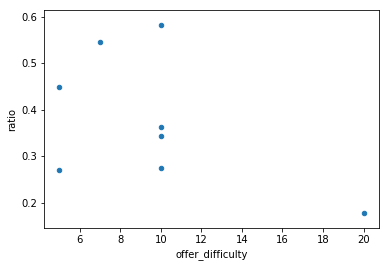

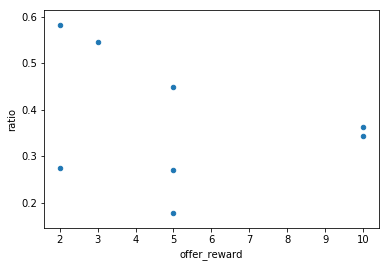

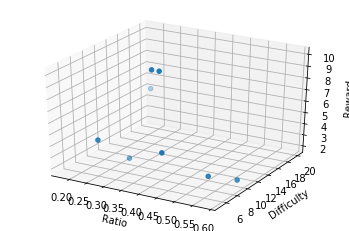

In [43]:
portfolio_counts.plot.scatter(x='offer_difficulty',y='ratio')
portfolio_counts.plot.scatter(x='offer_reward',y='ratio')
threedee = plt.figure().gca(projection='3d')
threedee.scatter(portfolio_counts['ratio'], portfolio_counts['offer_difficulty'], portfolio_counts['offer_reward'])
threedee.set_xlabel('Ratio')
threedee.set_ylabel('Difficulty')
threedee.set_zlabel('Reward')
plt.show()

In [44]:
portfolio_counts.groupby('offer_type').mean()

KeyError: 'offer_type'

Looking at the plots, I see a negative correlation between reward value and and completion ratio. For example, higher reward offers are completed less than the ones with same difficulty. 

I would assume that the lower the reward number in the data, the higher the real life value of the offer is. Note that, this contradicts with zero value of information offers.

Overall, both difficulty and reward metrics may need a calibration.

Let's have a deeper look into demographics. First, let's see if any gender responds to offers better. 

In [ ]:
transcript_df[transcript_df['event']=='offer completed']['gender'].value_counts()/df[df['event']=='offer viewed']['gender'].value_counts()

It can be seen that males react significantly less than females in offer completion rate. This can be due to average user age. Let's investigate the average 

In [47]:
transcript_df[transcript_df['event']=='offer completed'].shape

(32444, 16)